In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [2]:
from sedona.spark import *

config = SedonaContext.builder() \
    .master("local[*]") \
    .appName("SedonaSample") \
    .config('spark.jars.packages', 
            'org.apache.sedona:sedona-spark-3.5_2.12:1.6.0,'
            'org.datasyslab:geotools-wrapper:1.6.0-28.2'
        ) \
    .getOrCreate()
sedona = SedonaContext.create(config)

24/08/21 22:59:57 WARN Utils: Your hostname, Makotos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.138.143.20 instead (on interface en0)
24/08/21 22:59:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/Mak/.pyenv/versions/3.11.2/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/Mak/.ivy2/cache
The jars for the packages stored in: /Users/Mak/.ivy2/jars
org.apache.sedona#sedona-spark-3.5_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-17aad47b-fcce-404f-8209-d1ee131dd4bb;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-3.5_2.12;1.6.0 in central
	found org.apache.sedona#sedona-common;1.6.0 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.19.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.0.0 in central
	found com.google.errorprone#error_prone_annotations;2.1.3 in central
	found com.google.j2ob

In [3]:
sc = sedona.sparkContext

In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, DoubleType, StringType

schema = StructType([
    StructField("Vehicle_ID", IntegerType(), True),
    StructField("Frame_ID", IntegerType(), True),
    StructField("Total_Frames", IntegerType(), True),
    StructField("Global_Time", LongType(), True),
    StructField("Local_X", DoubleType(), True),
    StructField("Local_Y", DoubleType(), True),
    StructField("Global_X", DoubleType(), True),
    StructField("Global_Y", DoubleType(), True),
    StructField("v_length", DoubleType(), True),
    StructField("v_Width", DoubleType(), True),
    StructField("v_Class", IntegerType(), True),
    StructField("v_Vel", DoubleType(), True),
    StructField("v_Acc", DoubleType(), True),
    StructField("Lane_ID", IntegerType(), True),
    StructField("O_Zone", IntegerType(), True),
    StructField("D_Zone", IntegerType(), True),
    StructField("Int_ID", IntegerType(), True),
    StructField("Section_ID", IntegerType(), True),
    StructField("Direction", IntegerType(), True),
    StructField("Movement", IntegerType(), True),
    StructField("Preceding", IntegerType(), True),
    StructField("Following", IntegerType(), True),
    StructField("Space_Headway", DoubleType(), True),
    StructField("Time_Headway", DoubleType(), True),
    StructField("Location", StringType(), True)
])

In [8]:
data_path = "dataset/NGSIM_Data.csv"

df = sedona.read.csv(data_path, header=True, schema=schema)


In [6]:
df = df.filter((F.col("Location") == "us-101") & (F.col("Lane_ID") == 1)) \
    .withColumn("vel_dist", F.round(F.col("v_Vel"))) \
    .groupBy("vel_dist") \
    .count() \
    .sort("vel_dist")

24/08/21 23:00:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


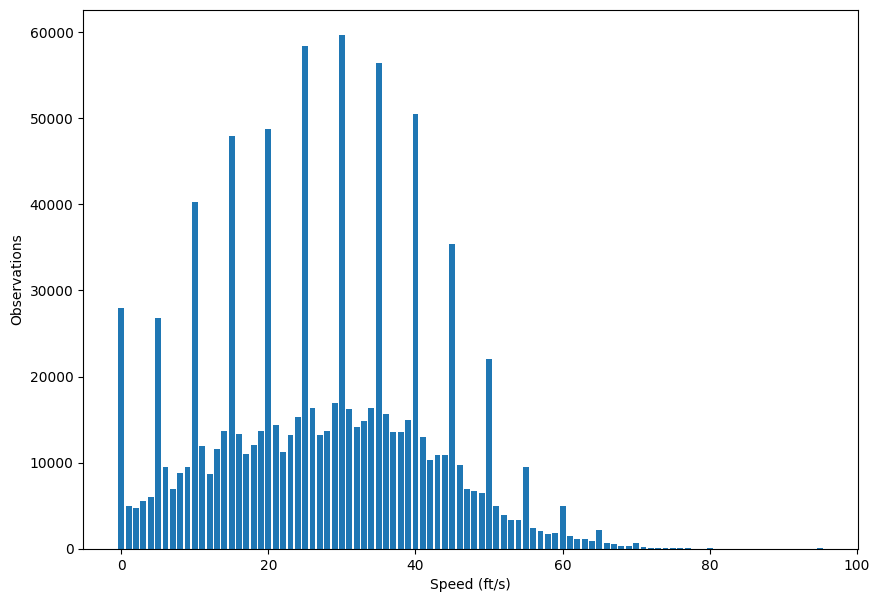

24/08/21 09:13:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1054725 ms exceeds timeout 120000 ms
24/08/21 09:13:19 WARN SparkContext: Killing executors is not supported by current scheduler.
24/08/21 09:13:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [24]:
import pandas as pd
from matplotlib import pyplot as plt

pdf = df.toPandas()
speed = pdf['vel_dist']
count = pdf['count']

# Figure Size
fig = plt.figure(figsize =(10, 7))

# Horizontal Bar Plot
plt.bar(speed, count)
plt.xlabel("Speed (ft/s)")
plt.ylabel("Observations")
plt.title("Lane 1")
# Show Plot
plt.show()


In [9]:
from utils.datapreprocessing_utils import *

df = df.withColumns({"v_Vel": F.col("v_Vel") / 1.46666667, "v_Acc": F.col("v_Acc") / 1.46666667}) # convert velocity and acceleration from fps to mph
df = convert_coordinate_system(df)
df = convert_timestamp(df)
df = add_distance_and_time_cols(df)

In [22]:
df.show()

+----------+--------+------------+-------------+-------+--------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+----------+--------------------+------------------+-------------------+--------------------+------------------+-----------+---+-----+----+----+
|Vehicle_ID|Frame_ID|Total_Frames|  Global_Time|Local_X| Local_Y|v_length|v_Width|v_Class|v_Vel|v_Acc|Lane_ID|O_Zone|D_Zone|Int_ID|Section_ID|Direction|Movement|Preceding|Following|Space_Headway|Time_Headway|  Location|            gps_geom|               lat|                lon|            datetime|          Distance|ElapsedTime|day|month|hour|year|
+----------+--------+------------+-------------+-------+--------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+----------+--------------------+------------------+-------------------+-----------------

In [11]:
df = df.withColumns({
    "day": F.dayofmonth(F.col("datetime")),
    "month": F.month(F.col("datetime")),
    "hour": F.hour(F.col("datetime")),
    "year": F.year(F.col("datetime")),
    })

In [56]:
df.cache()

DataFrame[Vehicle_ID: int, Frame_ID: int, Total_Frames: int, Global_Time: bigint, Local_X: double, Local_Y: double, v_length: double, v_Width: double, v_Class: int, v_Vel: double, v_Acc: double, Lane_ID: int, O_Zone: int, D_Zone: int, Int_ID: int, Section_ID: int, Direction: int, Movement: int, Preceding: int, Following: int, Space_Headway: double, Time_Headway: double, Location: string, gps_geom: udt, lat: double, lon: double, datetime: timestamp, Distance: double, ElapsedTime: bigint, day: int, month: int, hour: int, year: int]

In [44]:
counts = df.groupBy(["day", "month", "hour", "year", "Location"]).count()
counts.show()

24/07/11 19:04:33 WARN MemoryStore: Not enough space to cache rdd_29_2 in memory! (computed 29.5 MiB so far)
24/07/11 19:04:33 WARN MemoryStore: Not enough space to cache rdd_29_4 in memory! (computed 29.5 MiB so far)
24/07/11 19:04:33 WARN MemoryStore: Not enough space to cache rdd_29_0 in memory! (computed 29.5 MiB so far)
24/07/11 19:04:33 WARN MemoryStore: Not enough space to cache rdd_29_1 in memory! (computed 29.5 MiB so far)
24/07/11 19:04:33 WARN MemoryStore: Not enough space to cache rdd_29_5 in memory! (computed 29.5 MiB so far)
24/07/11 19:04:33 WARN MemoryStore: Not enough space to cache rdd_29_3 in memory! (computed 57.3 MiB so far)
24/07/11 19:04:39 WARN MemoryStore: Not enough space to cache rdd_127_5 in memory! (computed 29.7 MiB so far)
24/07/11 19:04:39 WARN BlockManager: Persisting block rdd_127_5 to disk instead.
24/07/11 19:04:39 WARN MemoryStore: Not enough space to cache rdd_127_2 in memory! (computed 29.7 MiB so far)
24/07/11 19:04:39 WARN BlockManager: Persisti

+---+-----+----+----+----------+-------+
|day|month|hour|year|  Location|  count|
+---+-----+----+----+----------+-------+
| 16|    6|   9|2005|lankershim|  41143|
| 13|    4|  15|2005|      i-80|  24208|
| 13|    4|  16|2005|      i-80|1249161|
| 16|    6|   8|2005|lankershim|1566176|
| 15|    6|   7|2005|    us-101| 737315|
| 15|    6|   8|2005|    us-101|4065618|
| 13|    4|  17|2005|      i-80|3293018|
| 14|    1|   3|1970| peachtree| 873887|
+---+-----+----+----+----------+-------+



### For i-80 dataset ###

In [13]:
i80 = df.filter(
    (F.col("Location") == "i-80") & (F.col("hour") == 15)
    ).sort("datetime")

In [14]:
i80.show()

24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_3 in memory! (computed 29.5 MiB so far)
24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_6 in memory! (computed 29.5 MiB so far)
24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_4 in memory! (computed 29.5 MiB so far)
24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_2 in memory! (computed 29.5 MiB so far)
24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_0 in memory! (computed 29.5 MiB so far)
24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_5 in memory! (computed 57.3 MiB so far)
24/07/08 17:15:49 WARN MemoryStore: Not enough space to cache rdd_29_8 in memory! (computed 29.0 MiB so far)
24/07/08 17:15:52 WARN MemoryStore: Not enough space to cache rdd_29_9 in memory! (computed 57.3 MiB so far)
24/07/08 17:15:53 WARN MemoryStore: Not enough space to cache rdd_29_10 in memory! (computed 29.5 MiB so far)
24/07/08 17:15:53 

+----------+--------+------------+-------------+-------+-------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+--------+--------------------+------------------+-------------------+--------------------+---+-----+----+-----------------+-----------+
|Vehicle_ID|Frame_ID|Total_Frames|  Global_Time|Local_X|Local_Y|v_length|v_Width|v_Class|v_Vel|v_Acc|Lane_ID|O_Zone|D_Zone|Int_ID|Section_ID|Direction|Movement|Preceding|Following|Space_Headway|Time_Headway|Location|            gps_geom|               lat|                lon|            datetime|day|month|hour|         Distance|ElapsedTime|
+----------+--------+------------+-------------+-------+-------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+--------+--------------------+------------------+-------------------+--------------------+---+-----+----+--

In [15]:
vehicle_count = i80.groupBy("Vehicle_ID").agg({"*": "count"}).count()
vehicle_count

24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_5 in memory! (computed 29.5 MiB so far)
24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_2 in memory! (computed 29.5 MiB so far)
24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_4 in memory! (computed 29.5 MiB so far)
24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_0 in memory! (computed 29.5 MiB so far)
24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_6 in memory! (computed 29.5 MiB so far)
24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_3 in memory! (computed 57.3 MiB so far)
24/07/08 17:16:02 WARN MemoryStore: Not enough space to cache rdd_29_8 in memory! (computed 29.0 MiB so far)
24/07/08 17:16:04 WARN MemoryStore: Not enough space to cache rdd_29_9 in memory! (computed 57.3 MiB so far)
24/07/08 17:16:04 WARN MemoryStore: Not enough space to cache rdd_29_10 in memory! (computed 29.5 MiB so far)
24/07/08 17:16:04 

85

In [18]:
i80lane = i80 \
    .select("Location", "ElapsedTime", "hour", "Distance", "Vehicle_ID", "Lane_ID", "v_Vel", "v_Acc") \
    .filter(
        (F.col("hour") == 15) & (F.col("Lane_ID") == 2)
    ) \
    .sort("ElapsedTime")

i80lane.show()

24/07/08 18:50:48 WARN MemoryStore: Not enough space to cache rdd_29_4 in memory! (computed 29.5 MiB so far)
24/07/08 18:50:48 WARN MemoryStore: Not enough space to cache rdd_29_8 in memory! (computed 29.0 MiB so far)
24/07/08 18:50:48 WARN MemoryStore: Not enough space to cache rdd_29_3 in memory! (computed 29.5 MiB so far)
24/07/08 18:50:48 WARN MemoryStore: Not enough space to cache rdd_29_5 in memory! (computed 29.5 MiB so far)
24/07/08 18:50:48 WARN MemoryStore: Not enough space to cache rdd_29_0 in memory! (computed 29.5 MiB so far)
24/07/08 18:50:49 WARN MemoryStore: Not enough space to cache rdd_29_6 in memory! (computed 29.5 MiB so far)
24/07/08 18:50:49 WARN MemoryStore: Not enough space to cache rdd_29_2 in memory! (computed 57.3 MiB so far)
24/07/08 18:50:49 WARN MemoryStore: Not enough space to cache rdd_29_9 in memory! (computed 57.3 MiB so far)
24/07/08 18:50:50 WARN MemoryStore: Not enough space to cache rdd_29_10 in memory! (computed 57.3 MiB so far)


+--------+-----------+----+-----------------+----------+-------+-----+-----+
|Location|ElapsedTime|hour|         Distance|Vehicle_ID|Lane_ID|v_Vel|v_Acc|
+--------+-----------+----+-----------------+----------+-------+-----+-----+
|    i-80|       1000|  16|53.48271706822682|         1|      2| 12.5|  0.0|
|    i-80|       1000|  16|90.96787688519504|        36|      3|12.45| 1.49|
+--------+-----------+----+-----------------+----------+-------+-----+-----+



24/07/08 18:50:50 WARN MemoryStore: Not enough space to cache rdd_29_11 in memory! (computed 57.3 MiB so far)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# to remove the outliers, 65000 for 4pm, 1050000 for 5pm, 5600000 for 6pm
i80lane_pd = i80lane \
    .filter((F.col("ElapsedTime") < 1050000)) \
    .toPandas()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

vehicles = i80lane_pd.groupby("Vehicle_ID")

fig, ax = plt.subplots()
norm = plt.Normalize(0, 60)

for _, points in vehicles:
    x = points["ElapsedTime"].to_numpy()
    y = points["Distance"].to_numpy()
    cols = points["v_Vel"].to_numpy()

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='rainbow_r', norm=norm)
    lc.set_array(cols)
    lc.set_linewidth(1)
    ax.add_collection(lc)
    
fig.colorbar(lc, ax=ax)
ax.set_xlim(0, 1050000)
ax.set_ylim(0, 1750)

ax.set_xlabel("Time Elapsed (ms)")
ax.set_ylabel("Distance (ft)")

plt.show()


In [ ]:
i80.createOrReplaceTempView("i80")
i80.head()

In [ ]:
import geopandas as gpd

pdf = i80.toPandas()
gdf = gpd.GeoDataFrame(pdf, geometry="gps_geom")

gdf.plot(
    figsize=(10, 10),
    column="v_Vel",
    cmap="RdBu",
    markersize=1,
    legend=True
)

In [ ]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(pdf, geometry="gps_geom")

gdf.plot(
    figsize=(10, 10),
    column="Lane_ID",
    cmap="RdBu",
    markersize=1,
    legend=True
)

In [ ]:
i80.show()

In [ ]:
zones_rdd = ShapefileReader.readToGeometryRDD(sc, "i80shapefiles")
# zones_rdd.CRSTransform()

from sedona.utils.adapter import Adapter
from space_partition import SpacePartition

zones_df = Adapter.toDf(zones_rdd, sedona)
grid_df = SpacePartition.generate_grid_cells(
    spark=sedona, 
    geo_df=zones_df, 
    geometry="geometry", 
    partitions_x=10, 
    partitions_y=10
    )


In [ ]:
grid_df.count()

### For us-101 ###

In [12]:
from utils.datapreprocessing_utils import *
us101 = us101_filter(df)
us101_7am = hour_filter(us101, "us-101", 7)

us-101 7h Data Filtered


In [13]:
max_elapsed_time = us101_7am.tail(1)[0]["ElapsedTime"]
max_elapsed_time # 620200 ms = 10.3 minutes

620200

In [14]:
max_dist = us101_7am.select("Distance").sort("Distance").tail(1)[0]["Distance"]
max_dist # 2196.1895...

2196.1895082210003

#### Geometry Visualisation ####

In [29]:
us101_7am.createOrReplaceTempView("us101_7am")
us101_7am.head()

24/08/14 15:31:15 WARN MemoryStore: Not enough space to cache rdd_32_0 in memory! (computed 29.7 MiB so far)


Row(Vehicle_ID=1779, Frame_ID=5317, Total_Frames=490, Global_Time=1118847510600, Local_X=31.09, Local_Y=733.063, v_length=28.0, v_Width=7.9, v_Class=3, v_Vel=49.92, v_Acc=1.69, Lane_ID=3, O_Zone=None, D_Zone=None, Int_ID=None, Section_ID=None, Direction=None, Movement=None, Preceding=1769, Following=1784, Space_Headway=189.54, Time_Headway=3.8, Location='us-101', gps_geom=<POINT (-120.877 37.138)>, lat=37.1377481725441, lon=-120.87747495402657, datetime=datetime.datetime(2005, 6, 15, 7, 58, 30, 600000), Distance=733.7219841799754, ElapsedTime=5414375300, day=15, month=6, hour=7, year=2005)

24/08/14 15:31:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_32_6 in memory.
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_0 in memory! (computed 1788.8 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_5 in memory! (computed 1789.3 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_1 in memory! (computed 1790.5 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_3 in memory! (computed 1789.7 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_4 in memory! (computed 1788.6 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_7 in memory! (computed 1757.8 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_2 in memory! (computed 1787.8 KiB so far)
24/08/14 15:31:16 WARN MemoryStore: Not enough space to cache rdd_32_6 in memory! (compute

AttributeError: PathCollection.set() got an unexpected keyword argument 'xlabel'

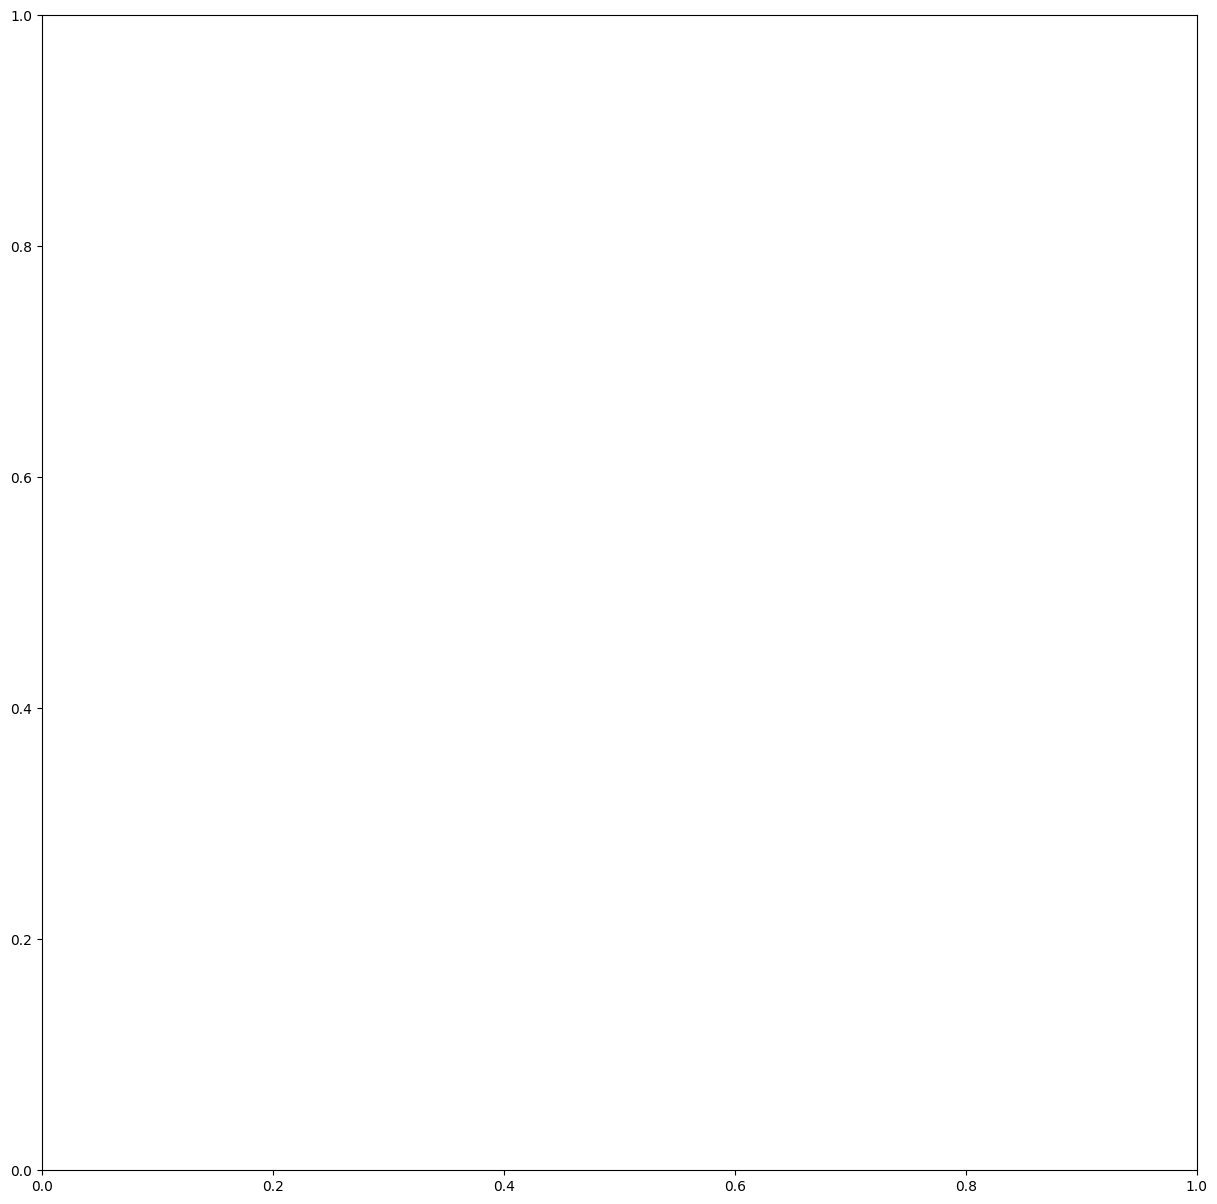

In [30]:
import geopandas as gpd

pdf_us101_7am = us101_7am.toPandas()
gdf_us101_7am = gpd.GeoDataFrame(pdf_us101_7am, geometry="gps_geom")

gdf_us101_7am.plot(
    figsize=(15, 15),
    column="v_Vel",
    cmap="RdBu",
    markersize=0.8,
    legend=True,
    xlabel="Longitude",
    ylabel="Latitude",
    label="Vehicle Speed (mph)"
)

#### Lane-wise shockwave visualisation ####


In [119]:
lane_id = 6

In [120]:
from utils.datapreprocessing_utils import lane_filter
us101_7am_lane = lane_filter(us101_7am, lane_id)

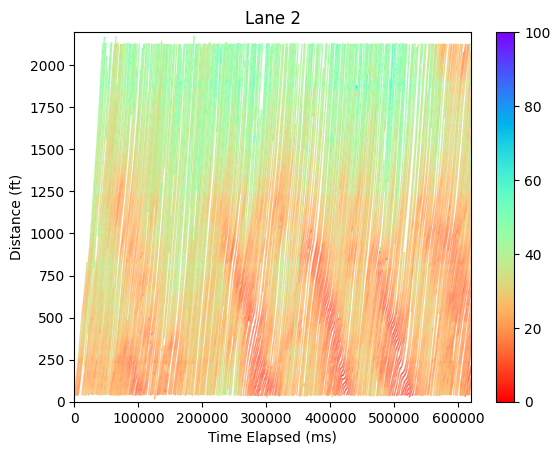

In [108]:
from utils.visualisation_utils import visualise_shockwave

visualise_shockwave(us101_7am_lane, lane_id, max_dist, max_elapsed_time)

24/08/14 19:49:47 WARN MemoryStore: Not enough space to cache rdd_112_2 in memory! (computed 29.7 MiB so far)
24/08/14 19:49:47 WARN MemoryStore: Not enough space to cache rdd_112_1 in memory! (computed 29.7 MiB so far)
24/08/14 19:49:47 WARN MemoryStore: Not enough space to cache rdd_112_4 in memory! (computed 29.7 MiB so far)
24/08/14 19:49:47 WARN MemoryStore: Not enough space to cache rdd_112_6 in memory! (computed 29.7 MiB so far)
24/08/14 19:49:47 WARN MemoryStore: Not enough space to cache rdd_112_5 in memory! (computed 29.7 MiB so far)
24/08/14 19:49:47 WARN MemoryStore: Not enough space to cache rdd_112_3 in memory! (computed 57.6 MiB so far)
24/08/14 19:49:50 WARN MemoryStore: Not enough space to cache rdd_112_9 in memory! (computed 29.5 MiB so far)
24/08/14 19:49:50 WARN MemoryStore: Not enough space to cache rdd_112_8 in memory! (computed 56.6 MiB so far)
24/08/14 19:49:50 WARN MemoryStore: Not enough space to cache rdd_112_10 in memory! (computed 29.5 MiB so far)
24/08/14 

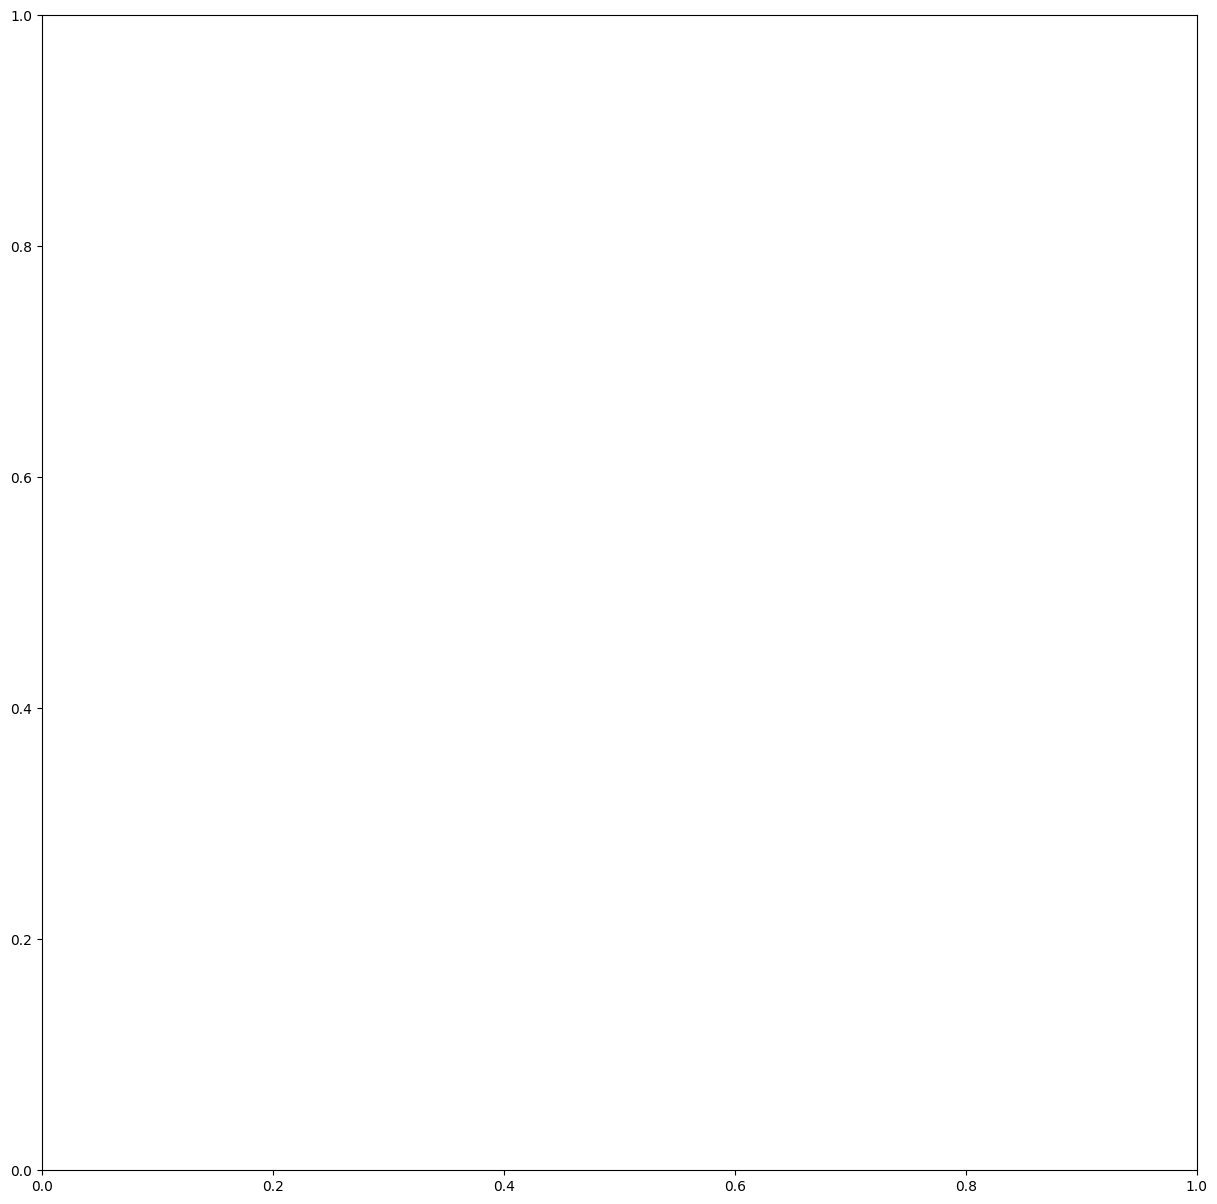

In [77]:
from utils.visualisation_utils import granular_snapshot

granular_snapshot(us101_7am, 500000)

#### Parameters for later operations ####

In [15]:
start, end, timewindow = 0, max_elapsed_time//1000, 30
num_section_splits = 9
history_len = 60
predict_len = 10

In [ ]:
num_section = 20
timestamp = 500000

In [16]:
us101_7am_section_agg = section_agg(us101_7am, max_dist, num_section_splits)

#### Snapshot at Time t (aggregated by section) ####

In [30]:
us101_7am_section_agg_snapshot = us101_7am_section_agg.filter((F.col("ElapsedTime") == timestamp))

24/07/11 21:46:34 WARN MemoryStore: Not enough space to cache rdd_23_7 in memory! (computed 28.5 MiB so far)
24/07/11 21:46:34 WARN MemoryStore: Not enough space to cache rdd_23_4 in memory! (computed 29.0 MiB so far)
24/07/11 21:46:34 WARN MemoryStore: Not enough space to cache rdd_23_2 in memory! (computed 29.0 MiB so far)
24/07/11 21:46:34 WARN MemoryStore: Not enough space to cache rdd_23_3 in memory! (computed 29.0 MiB so far)
24/07/11 21:46:34 WARN MemoryStore: Not enough space to cache rdd_23_5 in memory! (computed 29.0 MiB so far)
24/07/11 21:46:34 WARN MemoryStore: Not enough space to cache rdd_23_1 in memory! (computed 56.4 MiB so far)
24/07/11 21:46:35 WARN MemoryStore: Not enough space to cache rdd_23_9 in memory! (computed 29.4 MiB so far)
24/07/11 21:46:35 WARN MemoryStore: Not enough space to cache rdd_23_8 in memory! (computed 55.3 MiB so far)
24/07/11 21:46:36 WARN MemoryStore: Not enough space to cache rdd_23_11 in memory! (computed 29.4 MiB so far)
24/07/11 21:46:36 

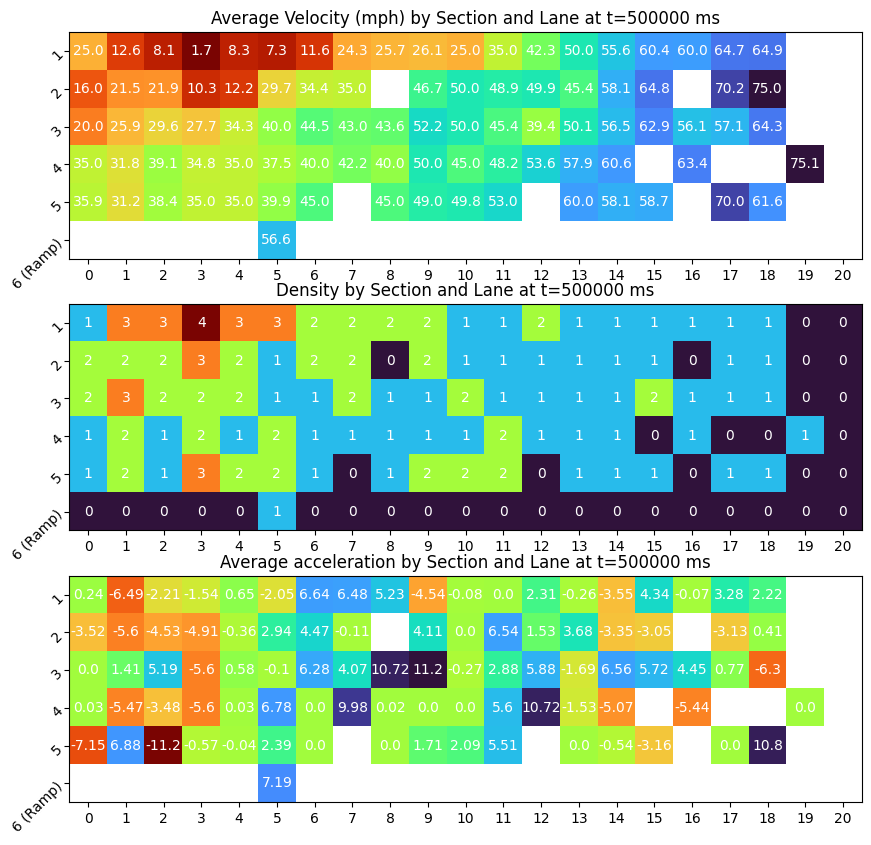

In [31]:
from utils.visualisation_utils import us101_section_vis
us101_section_vis(us101_7am_section_agg_snapshot, num_section_split, timestamp=f"{timestamp} ms")

In [32]:
# for visualisation, 30 sec windows -> how many cars in each block within each min?
350, 30

#### Timewindow-wise matrix visualisation ####

In [17]:
timewindow_df = timewindow_agg(us101_7am_section_agg, start, end, timewindow)

Time Window Aggregation Sample Result: 


+----------+----------+-------+----------+----------+-----+
|TimeWindow|Section_ID|Lane_ID|avg(v_Vel)|avg(v_Acc)|count|
+----------+----------+-------+----------+----------+-----+
|         1|         5|      3|      38.4|      0.16|  300|
+----------+----------+-------+----------+----------+-----+
only showing top 1 row



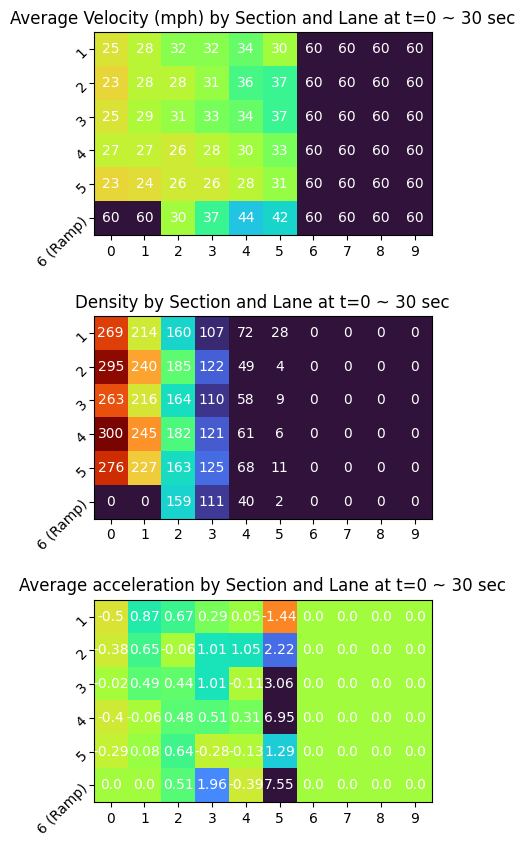

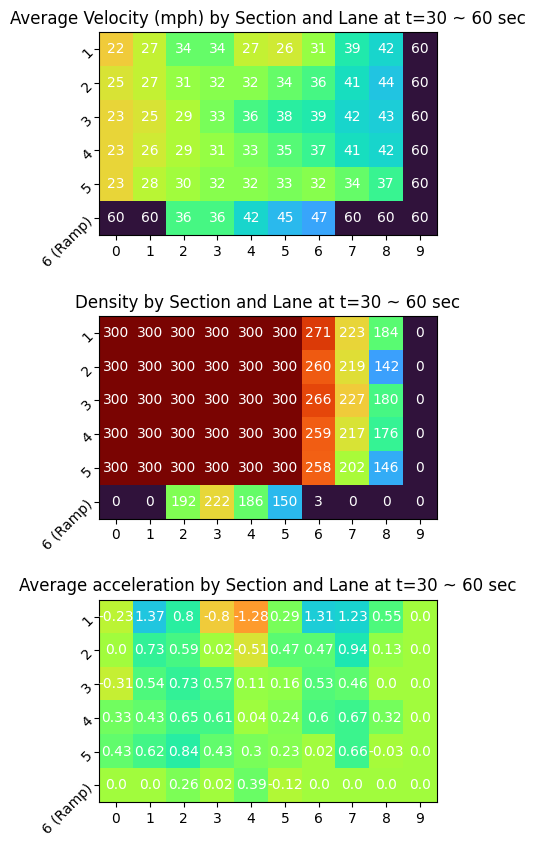

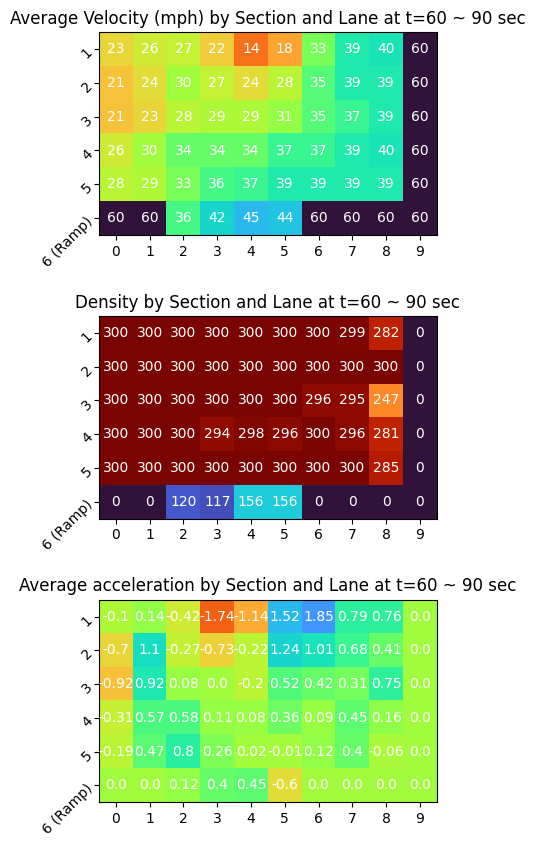

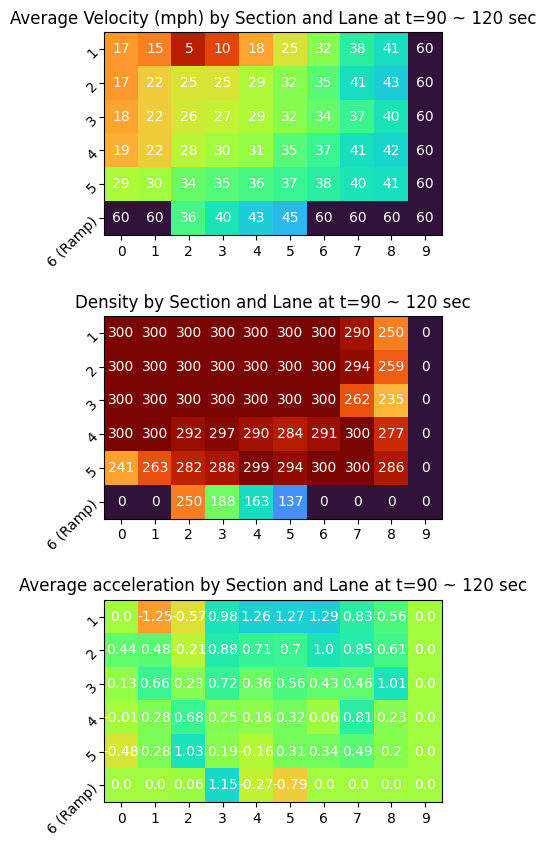

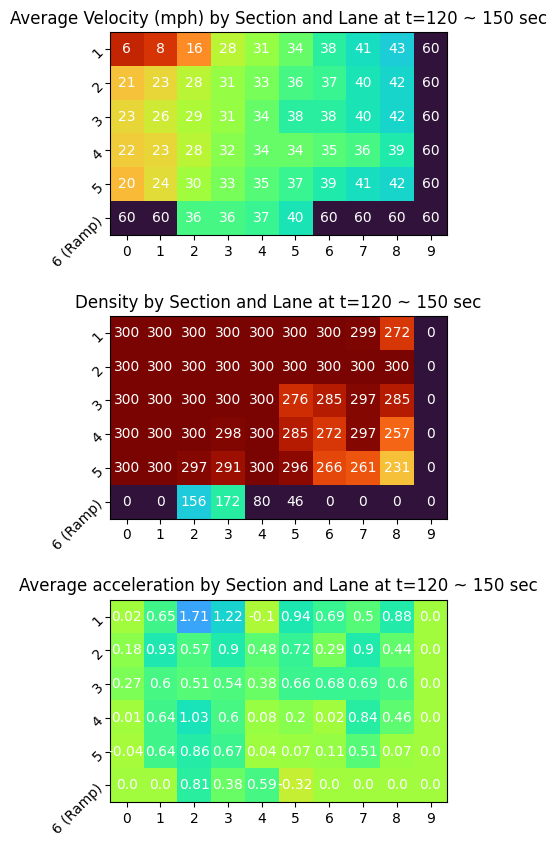

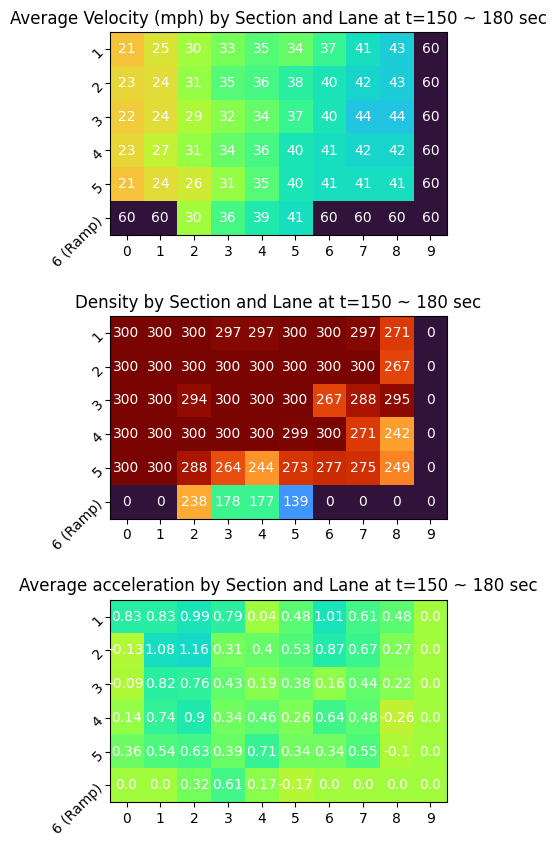

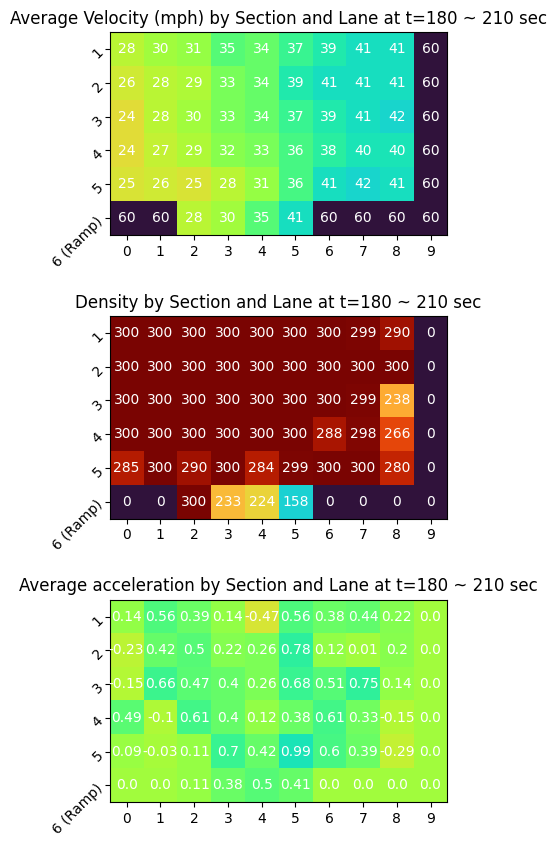

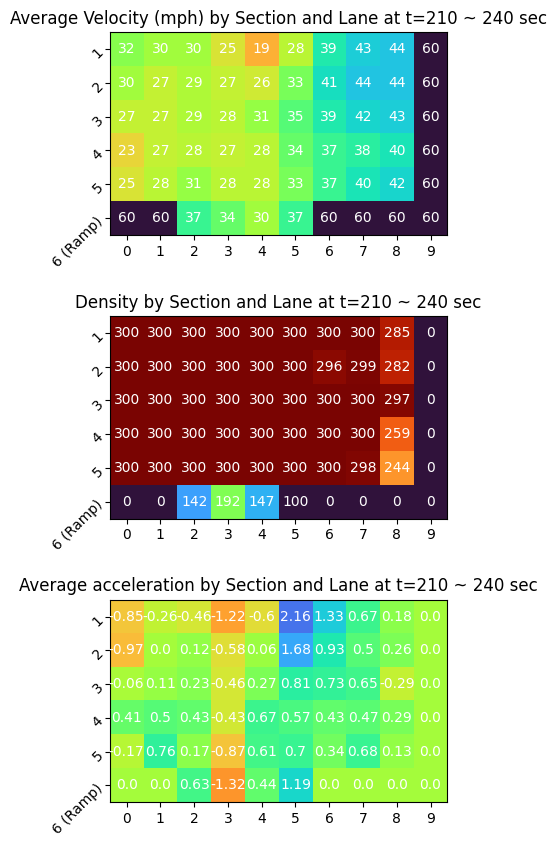

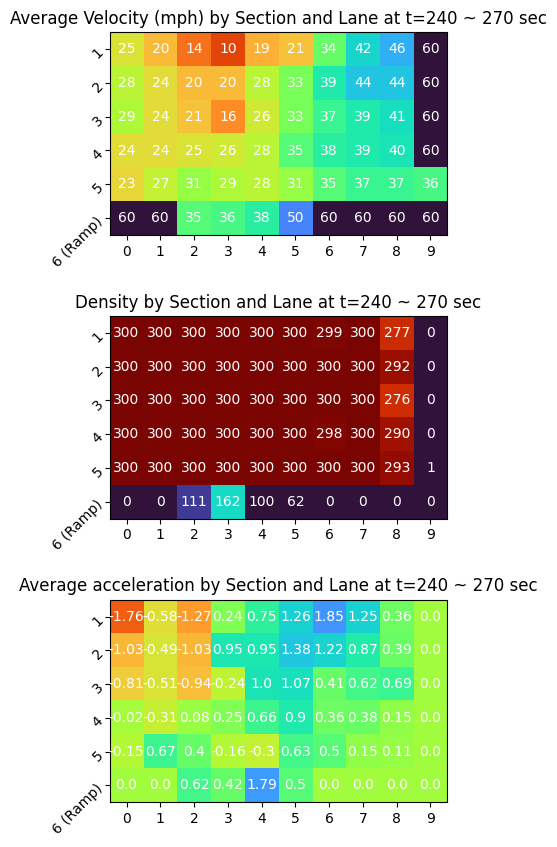

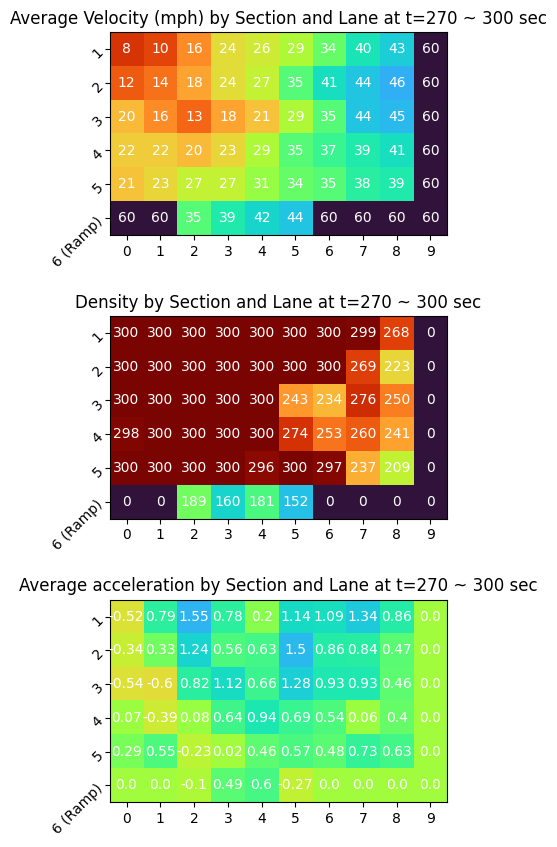

ERROR:root:KeyboardInterrupt while sending command.                (0 + 8) / 12]
Traceback (most recent call last):
  File "/Users/Mak/.pyenv/versions/3.11.2/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Mak/.pyenv/versions/3.11.2/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Mak/.pyenv/versions/3.11.2/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:695)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:660)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:636)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:582)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:541)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [19]:
from utils.visualisation_utils import us101_section_vis

for i in range(0, 12):
    filtered_df = timewindow_df.filter(F.col("TimeWindow") == i)
    us101_section_vis(filtered_df, num_section_splits, timestamp=f"{str(i*timewindow)} ~ {str(((i+1)*timewindow))} sec", with_ramp=True)

In [8]:
sc.stop()